# Insert size binned stats

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/fragment_length_qual_dependence")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")


In [2]:
def parse_data(file, key, astype=int):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(list(map(astype, line.strip().split("\t")[1:])))

    if data:
        cols = list(map(str, range(len(data[0]))))
        return pd.DataFrame(data, columns=cols)
    else:
        return pd.DataFrame()

## Quality and Mismatch data
### Load data

In [3]:
data = []
maxq = 0
for file in basedir.rglob("*.txt"):

    file_name = file.stem
    cell = file.parent.stem
    run = file.parent.parent.stem
    _, read, insert = file_name.split("_")
    insert = int(insert.split(".")[0])
    
    key = "FFQ" if read == "R1" else "LFQ"
    dfq = parse_data(file, key)
    
    if len(dfq) == 0:
        print("SKIP no data", run, cell, insert)
        continue

    quals = list(range(0, dfq.shape[1]-1))
    maxq = max(maxq, max(quals))
    
    dfq.columns = ["Cycle"] + quals
    
    dq = dfq.loc[:, quals].copy()
    if dq.iloc[0,:].sum() < 100:
        print("SKIP <100 reads", run, cell, insert)
        continue
    
    geq30 = [q for q in quals if q >= 30]
    ltq30 = [q for q in quals if q < 30]
    dfq["Pct_ge_30"] = dq[geq30].sum(axis=1) / dq[quals].sum(axis=1) * 100
    dfq["MeanQual"] = np.sum(dq * np.array(quals), axis=1) / dq.sum(axis=1)
    dfq["MeanError"] = np.sum(dq * (10 ** (-np.array(quals)/10)), axis=1) / dq.sum(axis=1)
    dfq["MeanErrorQ"] = dfq["MeanError"].apply(lambda x: -10*np.log10(x))
    dfq["Bases"] = dq.sum(axis=1)
    dfq["BasesQ30"] = dq[geq30].sum(axis=1)
    dfq["BasesltQ30"] = dq[ltq30].sum(axis=1)

    #dfq = dfq.drop(quals, axis=1)
    dfq["InsertBin"] = insert
    dfq["Read"] = read

    dm = parse_data(file, "MPC")
    quals = list(range(0, dm.shape[1]-2))
    geq30 = [q for q in quals if q >= 30]
    leq30 = [q for q in quals if q < 30]
    dm.columns = ["Cycle", "Ns"] + quals
    dm = dm[dm["Cycle"].isin(dfq["Cycle"])]
    dfq["Mismatches"] = dm.iloc[:,3:].sum(axis=1).values
    dfq["Mismatches per base"] = 100* dfq["Mismatches"] / dfq["Bases"]
    dfq["MismatchesQ30"] = dm[geq30].sum(axis=1).values
    dfq["MismatchesltQ30"] = dm[leq30].sum(axis=1).values
    dfq["Mismatches per base Q30"] = 100* dfq["MismatchesQ30"] / dfq["BasesQ30"]
    dfq["Mismatches per base ltQ30"] = 100* dfq["MismatchesltQ30"] / dfq["BasesltQ30"]
    dfq["Read"] = read
    dfq["Cell line"] = cell
    dfq["Run"] = run
    dfq["Sample"] = run + "_" + cell + "_"

    # Cap qualities for short inserts
    if insert in [0, 50, 100]:
        #dfq = dfq[dfq["Cycle"] < (int(insert) + 50)]
        dfq.loc[(dfq["Cycle"] >= (int(insert) + 50)), ["MeanQual", "MeanError", "MeanErrorQ", "Bases", "Mismatches", "Mismatches per base"]] = np.nan

    # Correct bin for aviti HQ run as Adept kit was used for cicularization
    # This adds an additional 50 bp to each fragment
    dfq["FragmentBin"] = dfq["InsertBin"]
    if run == "aviti_hq":
        dfq["FragmentBin"] += 50
    
    if read == "R2":
        dfq["Cycle"] += 150
    
    data.append(dfq)

data = pd.concat(data)
data = data.reset_index(drop=True)
data["Data source"] = data["Run"].replace(run_names)

data.head()

SKIP <100 reads aviti_ngi OPM2 800
SKIP <100 reads aviti_ngi OPM2 800
SKIP <100 reads aviti_ngi KMS12BM 800
SKIP <100 reads aviti_ngi KMS12BM 800


,Cycle,0,1,2,3,4,5,6,7,8,...,Mismatches per base,MismatchesQ30,MismatchesltQ30,Mismatches per base Q30,Mismatches per base ltQ30,Cell line,Run,Sample,FragmentBin,Data source
0,1,37,0,0,39,28,31,51,27,36,...,0.183147,2157,146,0.172360,2.430093,REH,aviti_hq,aviti_hq_REH_,350,AVITI CB
1,2,29,0,0,13,33,24,29,28,34,...,0.132649,1601,67,0.128025,0.967928,REH,aviti_hq,aviti_hq_REH_,350,AVITI CB
2,3,0,0,1,7,17,15,18,15,30,...,0.121356,1486,40,0.118721,0.691443,REH,aviti_hq,aviti_hq_REH_,350,AVITI CB
3,4,0,0,0,20,37,27,19,28,31,...,0.122946,1469,77,0.117391,1.265199,REH,aviti_hq,aviti_hq_REH_,350,AVITI CB
4,5,0,0,1,39,68,59,67,49,59,...,0.121435,1384,143,0.111090,1.231061,REH,aviti_hq,aviti_hq_REH_,350,AVITI CB


### Bases distribution over inserts

<Axes: xlabel='InsertBin', ylabel='Norm bases'>

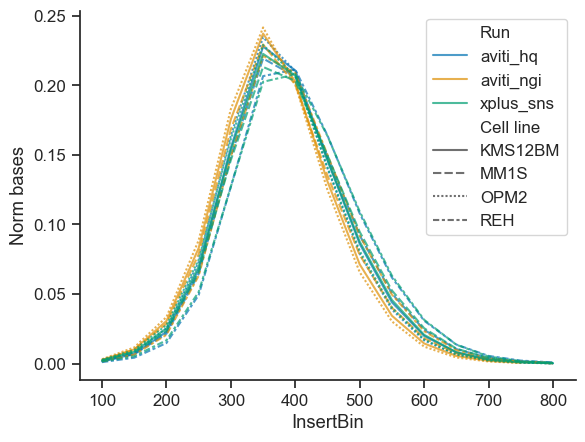

In [4]:
d = data.groupby(["InsertBin", "Run", "Cell line"], as_index=False)["Bases"].sum()
d["Norm bases"] = d.groupby(["Run", "Cell line"])["Bases"].transform(lambda x: x/x.sum())
sns.lineplot(d, x="InsertBin", y="Norm bases", hue="Run", style="Cell line", alpha=0.7)

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69712/821807510.py:5: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.relplot(d, x="InsertBin", y="Mismatches per base", hue="Data source", kind="line", markers="o",


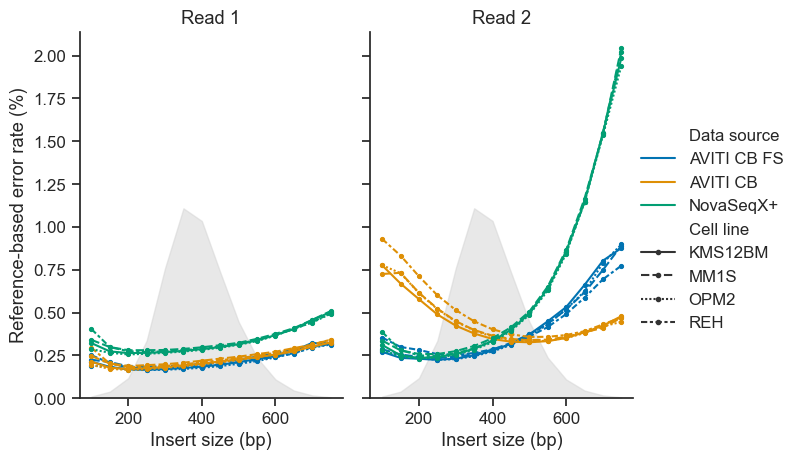

In [13]:
d = data.groupby(["Data source", "Cell line", "Read", "InsertBin"], as_index=False).agg({"Mismatches": "sum", "Bases":"sum"})
d["Read"] = d["Read"].replace({"R1": "Read 1", "R2": "Read 2"})
d["Mismatches per base"] = 100 * d["Mismatches"] / d["Bases"]
d = d[(d["InsertBin"] >= 50) & (d["InsertBin"] <= 750)].reset_index(drop=True)
g = sns.relplot(d, x="InsertBin", y="Mismatches per base", hue="Data source", kind="line", markers="o",
                markersize=3, markeredgecolor=None, 
            col="Read", hue_order=run_names.values(), style="Cell line", aspect=0.7, height=4.8,
               facet_kws=dict(sharey=True))#, fillstyle="full")

g.set(ylabel="Reference-based error rate (%)", xlabel="Insert size (bp)")
g.set_titles(col_template="{col_name}")
for read, ax in g.axes_dict.items():
    bases = d.query("Read == @read").groupby(["InsertBin"])["Bases"].sum()
    y = 5 * bases / bases.sum()
    x = bases.index
    ax.set_ylim(bottom=0)
    ax.fill_between(x, y, color="lightgrey", alpha=0.5)

fig = g.figure
fig.savefig(figdir / "error_rate_vs_reference_by_ins_size.svg")